In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset exported in Phase 1
daily = pd.read_csv("../data/clean_pm25.csv", parse_dates=["datetime"], index_col="datetime")

# Ensure 1-D Series (squeeze single-column DataFrame)
if isinstance(daily, pd.DataFrame):
    daily = daily.squeeze("columns")
daily.name = "pm25"

daily.head(), daily.index.min(), daily.index.max(), daily.shape, daily.isna().sum()


(datetime
 2010-01-01    129.000000
 2010-01-02    144.333333
 2010-01-03     78.375000
 2010-01-04     29.291667
 2010-01-05     43.541667
 Name: pm25, dtype: float64,
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 (2191,),
 0)

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAPE": mape(y_true, y_pred)
    }


In [69]:
H = 60  # evaluation horizon in days (try 30 or 60)

assert len(daily) > H + 30, "Not enough history for chosen H."
train = daily.iloc[:-H]
test  = daily.iloc[-H:]

train.shape, test.shape, (train.index.min(), train.index.max()), (test.index.min(), test.index.max())


((2131,),
 (60,),
 (Timestamp('2010-01-01 00:00:00'), Timestamp('2015-11-01 00:00:00')),
 (Timestamp('2015-11-02 00:00:00'), Timestamp('2015-12-31 00:00:00')))

In [70]:
# Try to get an order from pmdarima.auto_arima; else fall back to (1,0,1)
try:
    import pmdarima as pm
    arima_auto = pm.auto_arima(
        train.astype(float),
        start_p=0, start_q=0, max_p=5, max_q=5,
        d=None,                 # let it difference if needed
        seasonal=False,
        information_criterion="aic",
        stepwise=True, suppress_warnings=True,
        error_action="ignore",
        sarimax_kwargs={"enforce_stationarity": True, "enforce_invertibility": True}
    )
    order = getattr(arima_auto, "order_", (1,0,1))
except Exception:
    order = (1,0,1)

print("Using ARIMA order:", order)

from statsmodels.tsa.arima.model import ARIMA
arima_sm = ARIMA(train.astype(float), order=order).fit()
arima_sm.summary()


Using ARIMA order: (1, 0, 1)


c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pm25   No. Observations:                 2131
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -11761.663
Date:                Thu, 23 Oct 2025   AIC                          23531.327
Time:                        16:04:45   BIC                          23553.984
Sample:                    01-01-2010   HQIC                         23539.619
                         - 11-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.2003      3.398     27.428      0.000      86.540      99.860
ar.L1          0.3678      0.027     13.711      0.000       0.315       0.420
ma.L1          0.2924      0.030      9.618      0.000       0.233       0.352
sigma2      3648.7882     86.371     42.245      0.000    3479.504    3818.073
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               476.36
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.66
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
pred_test = arima_sm.get_forecast(steps=len(test)).predicted_mean
pred_test.index = test.index  # align

metrics_arima = evaluate(test.to_numpy().ravel(), pred_test.to_numpy().ravel())
metrics_arima


c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 94.78278070033612,
 'RMSE': 129.95377221995497,
 'MAPE': 153.22459109136398}

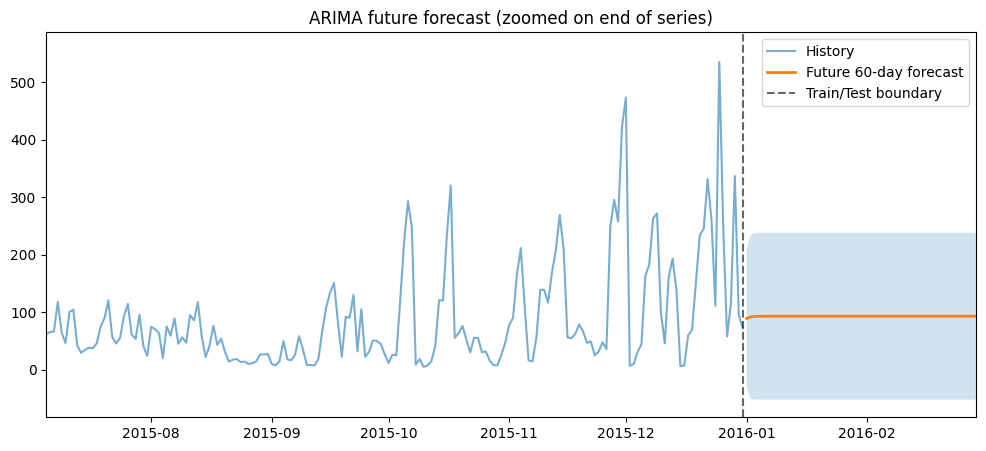

2016-01-01    89.149164
2016-01-02    91.710143
2016-01-03    92.652181
2016-01-04    92.998703
2016-01-05    93.126168
Freq: D, Name: predicted_mean, dtype: float64

In [72]:
future_res = arima_sm.get_forecast(steps=H)
future_mean = future_res.predicted_mean
future_ci   = future_res.conf_int()

# Future index = day after last observation
future_idx = pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=H, freq="D")
future_mean.index = future_idx
future_ci.index   = future_idx

plt.figure(figsize=(12,5))
plt.plot(daily, label="History", alpha=0.6)
plt.plot(future_mean, label=f"Future {H}-day forecast", linewidth=2)

# Confidence interval shading
lo = future_ci.iloc[:,0]
hi = future_ci.iloc[:,1]
plt.fill_between(future_mean.index, lo, hi, alpha=0.2)

# Train/Test boundary
plt.axvline(daily.index[-1], color="k", linestyle="--", alpha=0.6, label="Train/Test boundary")

# Zoom on last 6 months + forecast
plt.xlim(daily.index[-180], future_mean.index[-1])
plt.title("ARIMA future forecast (zoomed on end of series)")
plt.legend(); plt.show()

# Save for app/reporting
future_mean.rename("forecast").to_frame().to_csv("../data/forecast_arima.csv")
future_mean.head()


In [73]:
import pmdarima as pm

sarima = pm.auto_arima(
    train,
    start_p=0, start_q=0, max_p=3, max_q=3,
    d=None,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    seasonal=True, m=7,               # weekly seasonality for daily data
    information_criterion="aic",
    stepwise=True, suppress_warnings=True,
    error_action="ignore",
    sarimax_kwargs={"enforce_stationarity": True, "enforce_invertibility": True}
)
sarima.summary()

pred_test_s = pd.Series(sarima.predict(n_periods=len(test)), index=test.index)
metrics_sarima = evaluate(test.to_numpy().ravel(), pred_test_s.to_numpy().ravel())
metrics_sarima


c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 100.62503058855695,
 'RMSE': 144.4506736939196,
 'MAPE': 110.9485388728035}

In [74]:
y_train_log = np.log1p(train)

sarima_log = pm.auto_arima(
    y_train_log,
    start_p=0, start_q=0, max_p=3, max_q=3,
    d=None,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    seasonal=True, m=7,
    information_criterion="aic",
    stepwise=True, suppress_warnings=True,
    error_action="ignore",
    sarimax_kwargs={"enforce_stationarity": True, "enforce_invertibility": True}
)

# Predict test in log-space, then invert
y_pred_log = sarima_log.predict(n_periods=len(test))
pred_test_log = pd.Series(np.expm1(y_pred_log), index=test.index)

metrics_sarima_log = evaluate(test.to_numpy().ravel(), pred_test_log.to_numpy().ravel())
metrics_sarima_log


c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 109.56765807034022,
 'RMSE': 156.16053494362677,
 'MAPE': 91.91677684063026}

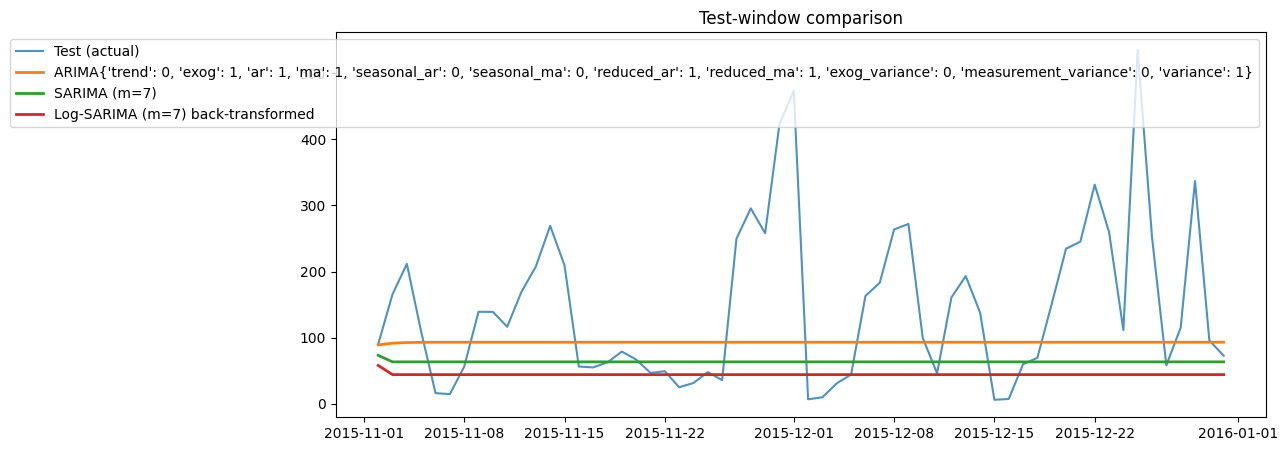

({'MAE': 94.78278070033612,
  'RMSE': 129.95377221995497,
  'MAPE': 153.22459109136398},
 {'MAE': 100.62503058855695,
  'RMSE': 144.4506736939196,
  'MAPE': 110.9485388728035},
 {'MAE': 109.56765807034022,
  'RMSE': 156.16053494362677,
  'MAPE': 91.91677684063026})

In [75]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Test (actual)", alpha=0.8)
plt.plot(pred_test,     label=f"ARIMA{arima_sm.model_orders}", linewidth=2)
plt.plot(pred_test_s,   label="SARIMA (m=7)", linewidth=2)
plt.plot(pred_test_log, label="Log-SARIMA (m=7) back-transformed", linewidth=2)
plt.title("Test-window comparison")
plt.legend(); plt.show()

metrics_arima, metrics_sarima, metrics_sarima_log


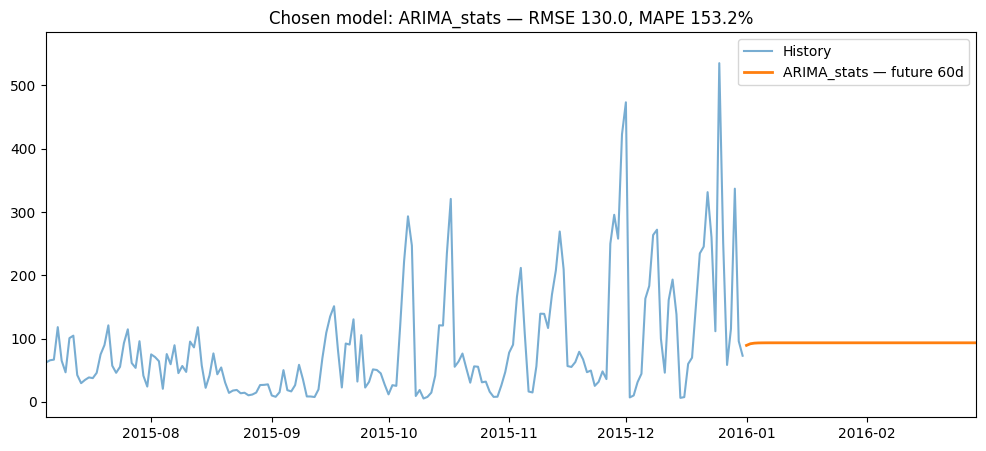

'../data/forecast_arima_stats.csv'

In [76]:
# Pick by RMSE (you can choose MAE/MAPE instead)
candidates = [
    ("ARIMA_stats",     arima_sm,      metrics_arima,     "arima_stats"),
    ("SARIMA_m7",       sarima,        metrics_sarima,    "sarima_m7"),
    ("SARIMA_m7_log",   sarima_log,    metrics_sarima_log,"sarima_m7_log")
]
best_name, best_model, best_metrics, tag = sorted(candidates, key=lambda x: x[2]["RMSE"])[0]
best_name, best_metrics

# Build a future forecast from the winner
if tag == "arima_stats":
    # statsmodels model
    future_res = best_model.get_forecast(steps=H)
    future_best = future_res.predicted_mean
    future_best.index = pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=H, freq="D")
elif tag == "sarima_m7":
    y_future = best_model.predict(n_periods=H)
    future_best = pd.Series(y_future, index=pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=H, freq="D"))
else:
    # log-SARIMA: predict in log-space then invert
    y_future_log = best_model.predict(n_periods=H)
    y_future = np.expm1(y_future_log)
    future_best = pd.Series(y_future, index=pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=H, freq="D"))

# Plot and save
plt.figure(figsize=(12,5))
plt.plot(daily, label="History", alpha=0.6)
plt.plot(future_best, label=f"{best_name} — future {H}d", linewidth=2)
plt.xlim(daily.index[-180], future_best.index[-1])
plt.title(f"Chosen model: {best_name} — RMSE {best_metrics['RMSE']:.1f}, MAPE {best_metrics['MAPE']:.1f}%")
plt.legend(); plt.show()

out_path = f"../data/forecast_{tag}.csv"
future_best.rename("forecast").to_frame().to_csv(out_path)
out_path
